In [3]:
%load_ext autoreload
%autoreload 2

In [40]:
# load all dependencies
import sys
import os
import torch
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')

from src.datamodule.maestro_datamodule import MaestroDataModule
from src.model.jukebox_diffusion import JukeboxDiffusion
from src.module.diffusion_attn_unet_1d import DiffusionAttnUnet1D

from IPython.display import Audio

In [5]:
def play_audio(audio: torch.Tensor, num_samples: int = 1):
    for a in torch.clamp(audio[:num_samples], -1, 1).cpu().numpy():
        display(Audio(a.flatten(), rate=44100))

# Load model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device= "cpu"
print(f'Using device: {device}')

Using device: cpu


In [7]:
#ckpt_path = '../logs/train/runs/2022-12-13_23-55-32/checkpoints/last.ckpt'
ckpt_path = "../logs/train/runs/2023-02-07_15-34-32/checkpoints/last.ckpt"
ckpt = torch.load(ckpt_path, map_location=device)

In [23]:
seqmodel = DiffusionAttnUnet1D(
        io_channels=64,
        n_attn_layers=6,
        channel_sizes=[128, 128, 128, 128, 256, 256, 256, 256, 512, 512]
    )

# remove all keys from state_dict that start with 'jukebox'
state_dict = {k: v for k, v in ckpt['state_dict'].items() if not k.startswith('jukebox_vqvae')}

model = JukeboxDiffusion(model=seqmodel, load_vqvae=False)
model.load_state_dict(state_dict=state_dict)
model = model.to(device)
model.hparams.jukebox_embedding_lvl = 1

In [24]:
model.prepare_data()
model.load_jukebox_vqvae(os.environ["JUKEBOX_VQVAE_PATH"])

Loading Jukebox VAE


# Load dataset

In [25]:
# check that decoding works
datamodule = MaestroDataModule(root_dir=os.environ['MAESTRO_DATASET_DIR'],
            batch_size=8,
            num_workers=4,
            sample_length= 131072)
datamodule.setup()
dataloader = datamodule.val_dataloader()
audio = next(iter(dataloader)).to(device)

Found 962 files. Getting durations
self.sr=44100, min: 3, max: inf
Keeping 962 of 962 files
Found 137 files. Getting durations
self.sr=44100, min: 3, max: inf
Keeping 137 of 137 files
Found 177 files. Getting durations
self.sr=44100, min: 3, max: inf
Keeping 177 of 177 files


# Inspect dataset

In [26]:
audio[0].shape

torch.Size([131072, 1])

In [27]:
sample_lvl2 = model.encode(audio.to(model.device), lvl=2)
sample_lvl1 = model.encode(audio.to(model.device), lvl=1)
sample_lvl0 = model.encode(audio.to(model.device), lvl=0)

In [28]:
audio_lvl2 = model.decode(sample_lvl2, lvl=2)
audio_lvl1 = model.decode(sample_lvl1, lvl=1)
audio_lvl0 = model.decode(sample_lvl0, lvl=0)

# Dataset sample statistics

In [58]:
import seaborn as sns
from einops import rearrange

def compute_sample_statistics(sample: torch.Tensor):
    return {
        'mean': sample.mean().item(),
        'std': sample.std().item(),
        'min': sample.min().item(),
        'max': sample.max().item(),
    }

def sample_histogram(sample: torch.Tensor, n_channels: int = 0, flatten=True):
    """
    Args:
        sample: [B, T, C]
        n_channels: number of channels to include in histogram. 0: all
        flatten: flatten along channels, If False, plot histogram for each channel
    """
    if n_channels == 0:
        n_channels = sample.shape[-1]
    if flatten:
        sample = rearrange(sample, 'b t c -> (b t) c')
        sample = sample[:, :n_channels].flatten()
        plt.hist(sample.detach().numpy(), bins=100)
        plt.xlabel("Value", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
    else:
        ncols = min(n_channels, 8)
        nrows = int(np.ceil(n_channels / ncols))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 6*nrows))
        for i, ax in enumerate(axes.flat):
            ax.hist(sample[:, :, i].detach().numpy().flatten(), bins=100)
            ax.axvline(x=0, color='red', linestyle='--')
            ax.set_xlabel("Value", fontsize=16)
            ax.set_ylabel("Frequency", fontsize=16)
    plt.show()

In [30]:
sample_lvl1.shape

torch.Size([8, 4096, 64])

### LVL2

In [31]:
compute_sample_statistics(sample_lvl2)

{'mean': 0.08181893825531006,
 'std': 2.5432400703430176,
 'min': -33.97757339477539,
 'max': 28.45880126953125}

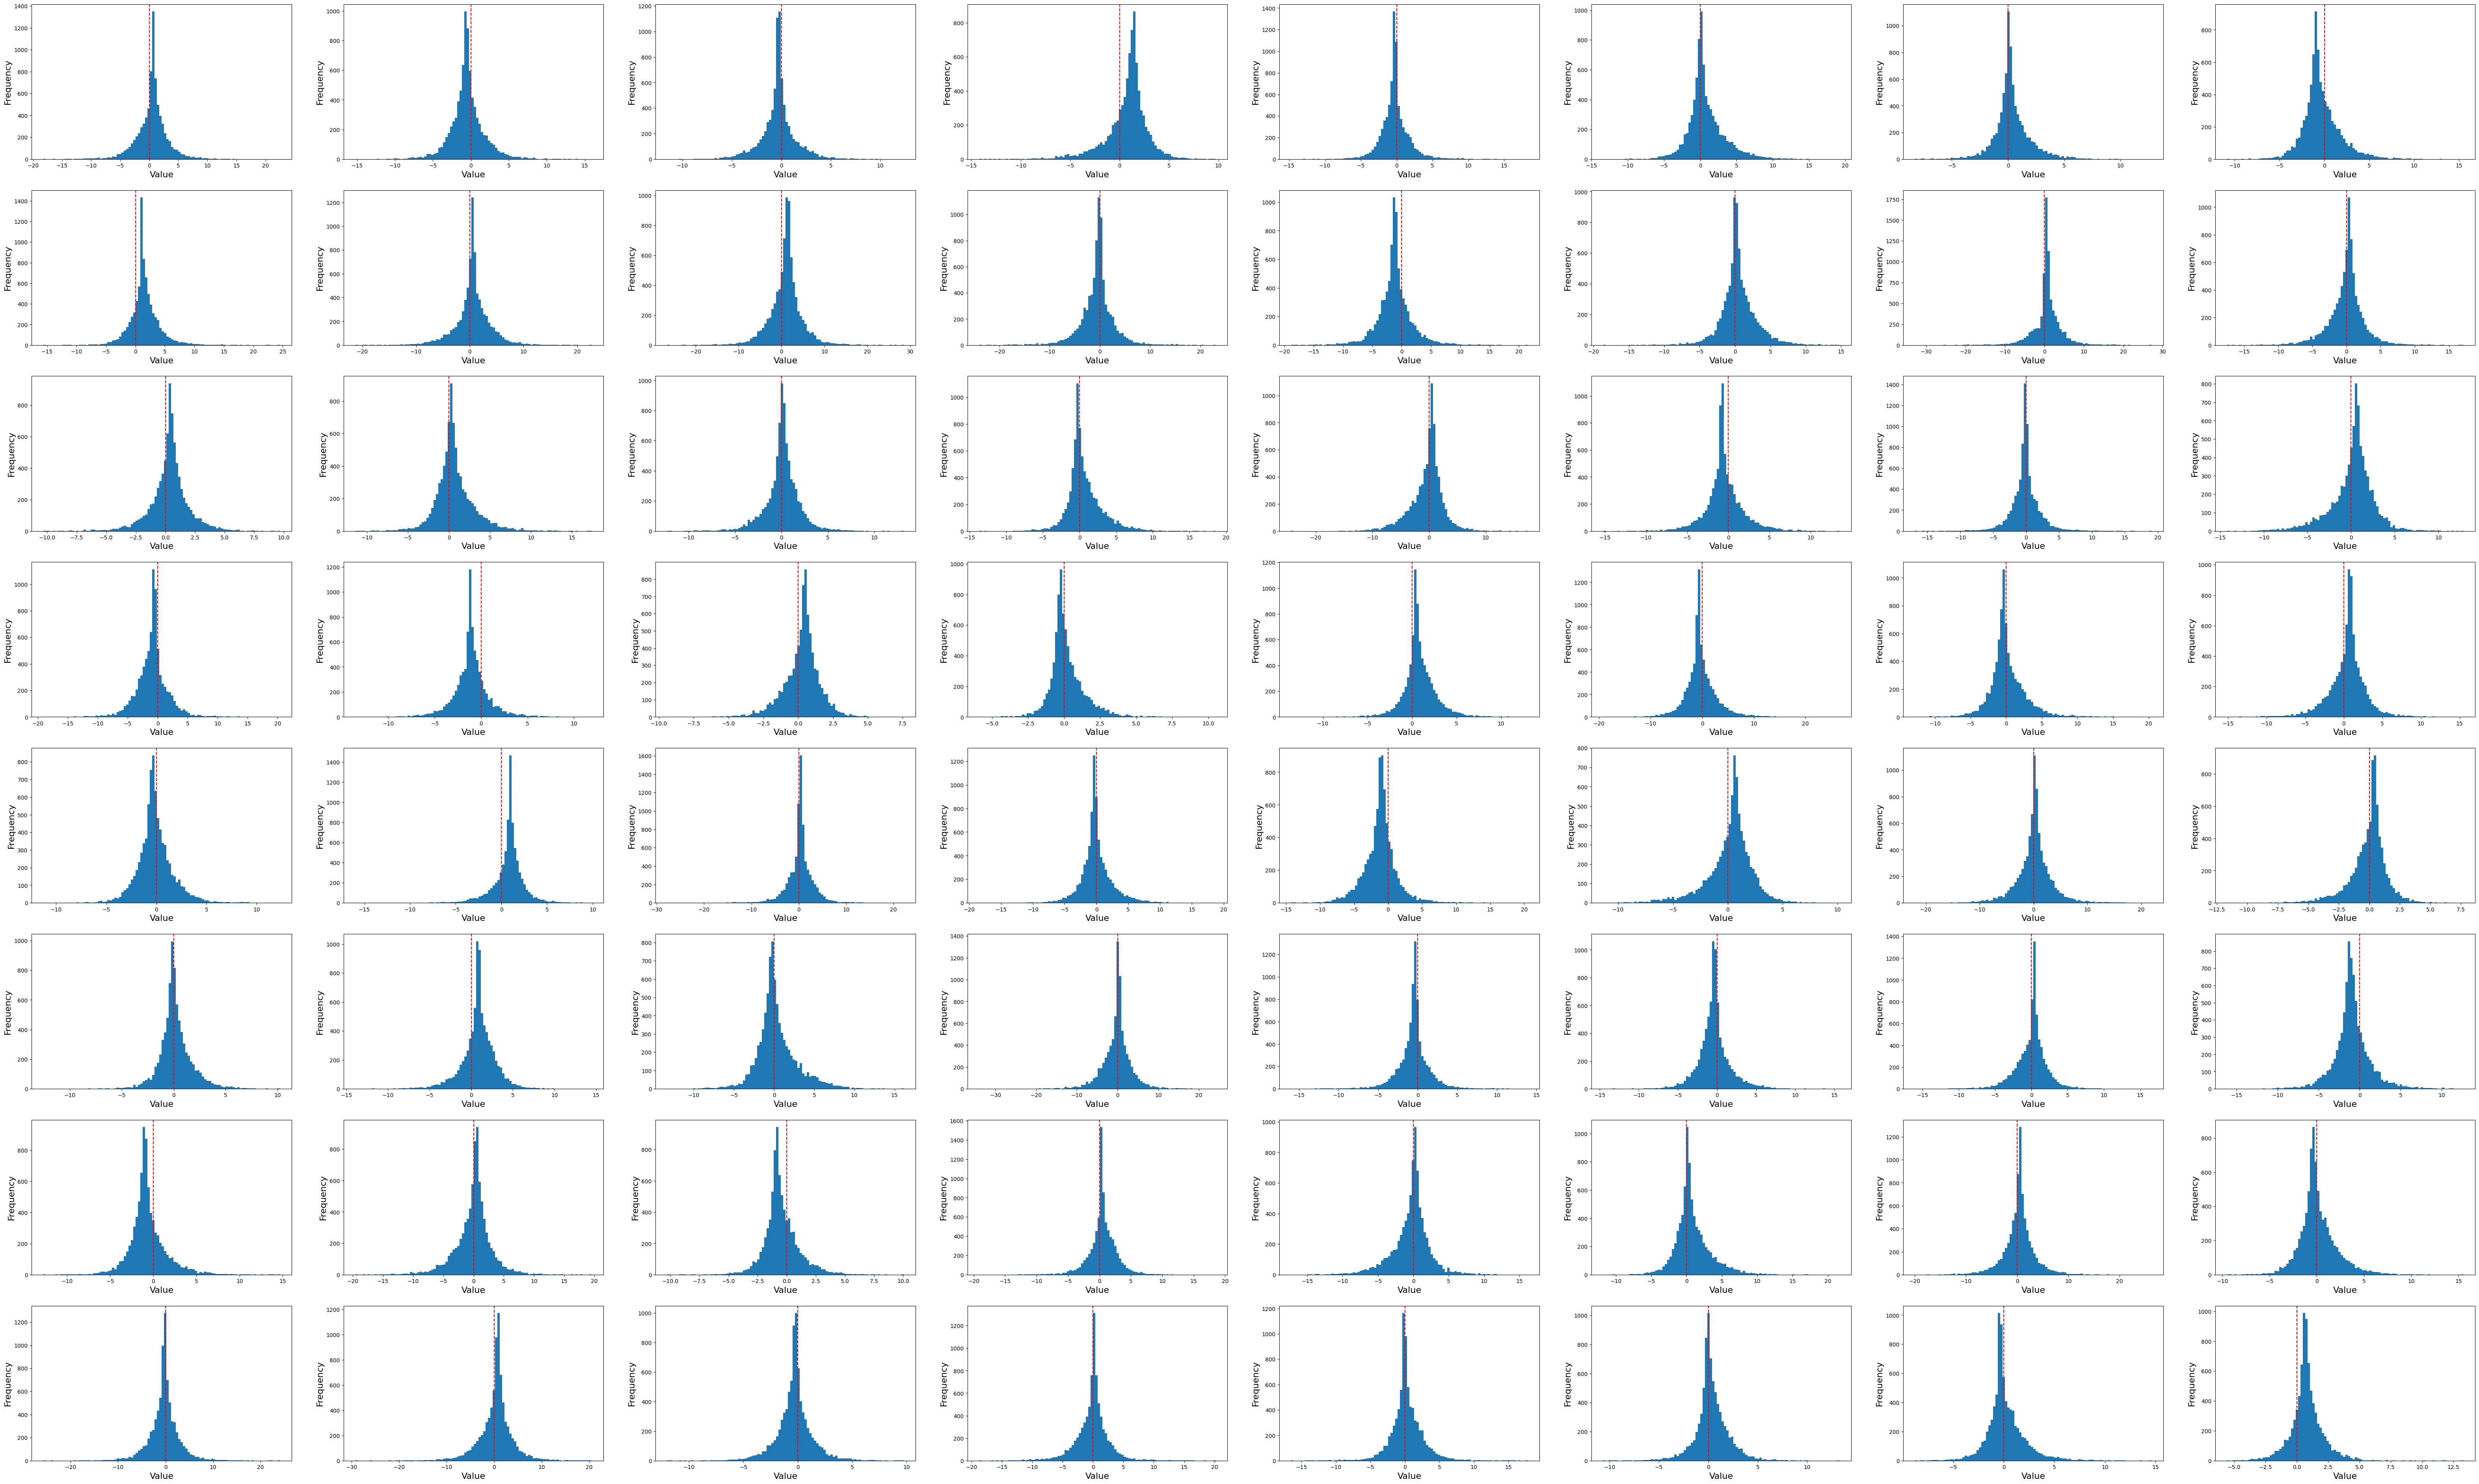

In [60]:
sample_histogram(sample_lvl2, n_channels=64, flatten=False)

### LVL1

In [32]:
compute_sample_statistics(sample_lvl1)

{'mean': -0.10868183523416519,
 'std': 3.9544284343719482,
 'min': -48.210113525390625,
 'max': 47.99407196044922}

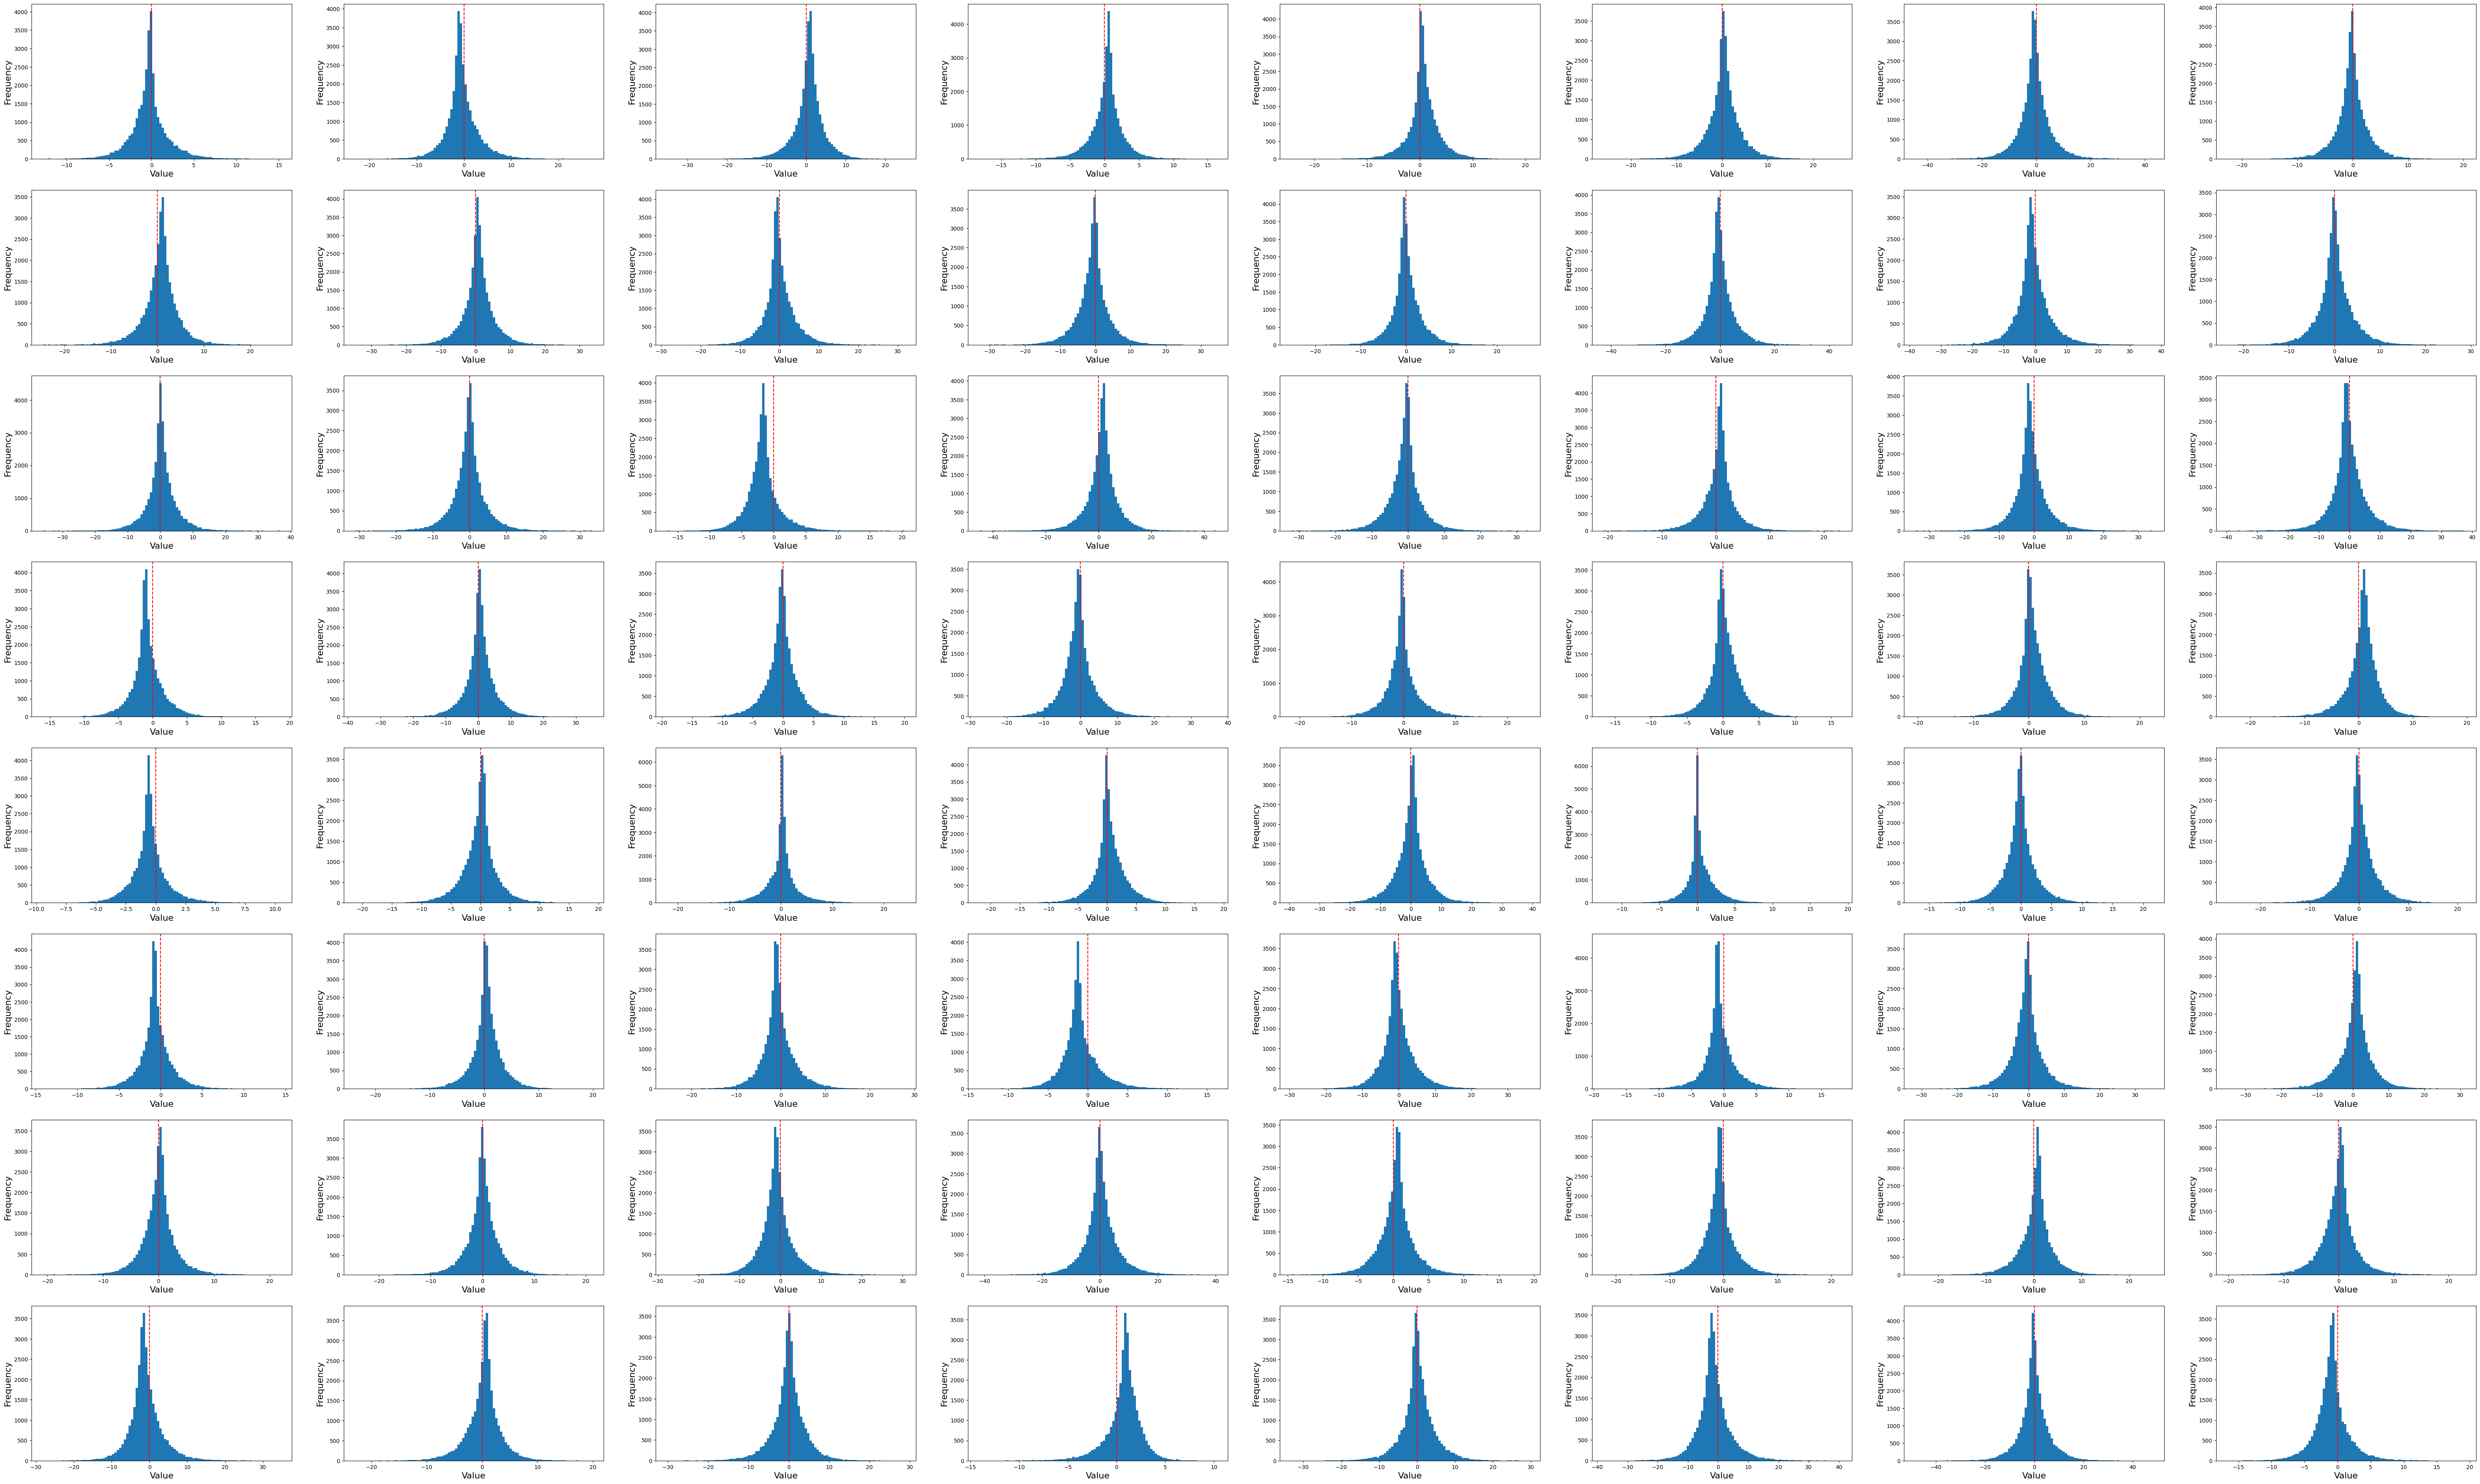

In [61]:
sample_histogram(sample_lvl1, n_channels=64, flatten=False)

### LVL0

In [33]:
compute_sample_statistics(sample_lvl0)

{'mean': -0.0004519122885540128,
 'std': 6.888402938842773,
 'min': -90.47019958496094,
 'max': 76.89507293701172}

In [ ]:
sample_histogram(sample_lvl0, n_channels=64, flatten=False)

# Play audio

### LVL2

In [66]:
play_audio(audio_lvl2, num_samples=4)

### LVL1

In [67]:
play_audio(audio_lvl1, num_samples=4)

### LVL0

In [68]:
play_audio(audio_lvl0, num_samples=4)

In [69]:
with torch.no_grad():
    embeddings = model.generate_unconditionally(
                batch_size=4,
                seq_len=2048,
                num_inference_steps=100,
                seed=420,
            )
    

  0%|          | 0/109 [00:00<?, ?it/s]

In [77]:
audio_gen = model.decode(embeddings*2, lvl=1)

In [75]:
compute_sample_statistics(embeddings*2)

{'mean': -0.031072372570633888,
 'std': 0.15392784774303436,
 'min': -0.9884622693061829,
 'max': 0.8574818968772888}

In [78]:
play_audio(audio_gen)